In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import seaborn as sns
import csv
import sqlite3
from datetime import datetime
from math import *
import pyreadr
from rpy2 import robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages
from scipy.stats import pearsonr
from scipy import stats

study_types = ['Pre','Mid','Post']

%matplotlib inline

In [7]:
class Participant:
    def __init__(self, ID):
        self.ID = ID
        self.studies = {}
        self.features = {}
        
    def add_study(self,study_type,study,day):
        """study_type = Pre, Mid, Posy
        study[day1] = [time series,CGM]
        """
        self.studies[(study_type,day)] = study
        #return self

    def add_feature(self,feature_name, feature_value):
        self.features[feature_name] = feature_value
        
    def get_study_type(self,study_type):
        l = {}
        for key,val in zip(self.studies.keys(),self.studies.values()):
            s,k = key
            if s == study_type:
                l[k] = self.studies[key]
        for key,val in zip(self.features.keys(),self.features.values()):
            s,k = key
            if s == study_type:
                l[k] = self.features[key]
        return l
    
    def export_file(self,study_type):
        shift_day=0
        if study_type == 'Pre':
            month = 1
        elif study_type == 'Mid':
            month = 2
            shift_day = 15
        elif study_type == 'Post':
            month = 4
        else:
            print('Error study type during "export_file"')
            
        with open('cgm.tsv','w',encoding='utf8',newline='') as tsv_file:
            tsv_writer = csv.writer(tsv_file,delimiter='\t',lineterminator='\n')
            tsv_writer.writerow(['GlucoseDisplayTime','GlucoseValue'])
            for key,val in zip(self.studies.keys(),self.studies.values()):
                s,day = key
                if s == study_type:
                    time,cgm = self.studies[key].CGM_x,self.studies[key].CGM_y
                    for t,c in zip(time,cgm):
                        hour=int(t/60)
                        minute=t%60
                        if hour==24:
                            hour=0
                        #print(hour,minute)
                        date = datetime(year=2021,month=month,day=int(float(day))+shift_day,hour=hour,minute=minute,second=0)
                        tsv_writer.writerow(['{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}'.format(
                            date.year,date.month,date.day,date.hour,date.minute,date.second),'{0}'.format(int(float(c)))])
                        #f.write("{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}    {6}\n".format(date.year,date.month,date.day,date.hour,date.minute,date.second,int(c)))

    #@property
    #def 
    
    #Prints object's information
    def __repr__(self):
        string = "Participant #{0}:".format(self.ID)
        for key,val in zip(self.studies.keys(),self.studies.values()):
            string = string + '\n Study ({0}, Day {1}): {2}'.format(*key,val)
        for key,val in zip(self.features.keys(),self.features.values()):
            string = string + '\n Feature ({0}, {1}): {2}'.format(*key,val)
        return string
  
    #Prints readable form
    #def __str__(self):
    #    return '%s + i%s' % (self.real, self.imag)

class Study:
    def __init__(self, day, CGM_x, CGM_y):
        #self.study_type = study_type
        self.day = day
        
        #self.CGM_x = np.array(CGM_x[~np.isnan(CGM_y)])
        #self.CGM_y = np.array(CGM_y[~np.isnan(CGM_y)])
        self.CGM_x = np.array(CGM_x)
        self.CGM_y = np.array(CGM_y)
        
    def __repr__(self):
        return "CGM_x {1} CGM_y {2}".format(self.day,type(self.CGM_x),type(self.CGM_y))

In [8]:
df1 = pd.ExcelFile('../Data/CGM_RAW_DATA.xlsx')
sheets = {}
for sheet_name in df1.sheet_names:
    if 'Input 1' in sheet_name:
        dftemp = df1.parse(sheet_name=sheet_name)
        dftemp = dftemp.replace('.',np.nan).dropna(axis=1,how='all')
        thresh = int(0.5*len(dftemp.loc[0,:]))
        if 'ID' in dftemp.columns:
            dftemp = dftemp.rename(columns={"ID": "time"})
        sheets[sheet_name] = dftemp.dropna(axis=0,thresh=thresh).replace(np.nan, 0)
print(sheets.keys())

dict_keys(['Pre Group 1 (Input 1)', 'Pre Group 2 (Input 1)', 'Mid Group 1 (Input 1)', 'Mid Group 2 (Input 1)', 'Post Group 1 (Input 1)', 'Post Group 2 (Input 1)'])


In [9]:
participants = {}

for sheet,sheet_name in zip(sheets.values(),sheets.keys()):
    study_type = sheet_name.split()[0]
    for col in sheet.columns:
        if 'Day' in str(col):
            ID, _, day = col.split()
            ID = int(ID)
            study = Study(day,sheet.get('time'),sheet.get(col))
            if ID in participants.keys():
                participants[ID].add_study(study_type,study,day)
            else:
                p = Participant(ID)
                p.add_study(study_type,study,day)
                participants[ID] = p

In [10]:
pre_data = []
mid_data = []
post_data = []

x_pre = []
x_mid = []
x_post = []

for p in participants.values():
    for study,study_key in zip(p.studies.values(),p.studies.keys()):
        #print(study,study_key)
        k1,k2 = study_key
        if k1 == 'Pre':
            x_pre.append(study.CGM_x)
            pre_data.append(study.CGM_y)
        if k1 == 'Mid':
            x_mid.append(study.CGM_x)
            mid_data.append(study.CGM_y)
        if k1 == 'Post':
            x_post.append(study.CGM_x)
            post_data.append(study.CGM_y)
            
pre_data = np.array(pre_data)
mid_data = np.array(mid_data)
post_data = np.array(post_data)

x_pre = np.array(x_pre)
x_mid = np.array(x_mid)
x_post = np.array(x_post)

pre_mean = np.mean(pre_data,axis=0)
mid_mean = np.mean(mid_data,axis=0)
post_mean = np.mean(post_data,axis=0)

x_pre_mean = np.mean(x_pre,axis=0)
x_mid_mean = np.mean(x_mid,axis=0)
x_post_mean = np.mean(x_post,axis=0)

pre_median = np.median(pre_data,axis=0)
mid_median = np.median(mid_data,axis=0)
post_median = np.median(post_data,axis=0)
print(pre_data.shape,mid_data.shape,post_data.shape)

(754, 288) (164, 288) (599, 288)


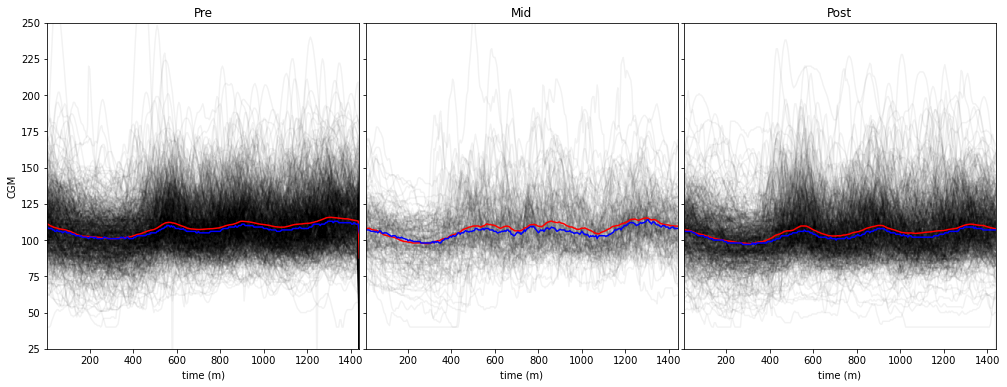

In [12]:
fig,(ax_pre,ax_mid,ax_post) = plt.subplots(1,3,figsize=(17,6),sharey=True)
fig.subplots_adjust(wspace=.02, hspace=0)

for p in participants.values():
    for study,study_key in zip(p.studies.values(),p.studies.keys()):
        #print(study,study_key)
        k1,k2 = study_key
        if k1 == 'Pre':
            ax_pre.plot(study.CGM_x,study.CGM_y,'k-',alpha=.05)
        if k1 == 'Mid':
            ax_mid.plot(study.CGM_x,study.CGM_y,'k-',alpha=.05)
        if k1 == 'Post':
            ax_post.plot(study.CGM_x,study.CGM_y,'k-',alpha=.05)
            
ax_pre.plot(x_pre_mean,pre_mean,'r')
ax_mid.plot(x_mid_mean,mid_mean,'r')
ax_post.plot(x_post_mean,post_mean,'r')

ax_pre.plot(x_pre_mean,pre_median,'b')
ax_mid.plot(x_mid_mean,mid_median,'b')
ax_post.plot(x_post_mean,post_median,'b')

ax_pre.set_title("Pre")
ax_mid.set_title("Mid")
ax_post.set_title("Post")

ax_pre.set_xlabel('time (m)')
ax_mid.set_xlabel('time (m)')
ax_post.set_xlabel('time (m)')
ax_pre.set_ylabel('CGM')

ax_pre.axis([min(x_pre_mean),max(x_pre_mean),25,250])
ax_mid.axis([min(x_pre_mean),max(x_pre_mean),25,250])
ax_post.axis([min(x_pre_mean),max(x_pre_mean),25,250])

#fig.tight_layout()
plt.show()

In [14]:
df2 = pd.read_excel('../Data/MEDGI-CARB_MASTER_DATA_new.xlsx',skiprows=[0])
#df2 = df2.parse(sheet_name=0)

dftemp = df2.replace('.',np.nan).dropna(axis=1,how='all')
thresh = int(0.5*len(dftemp.loc[0,:]))

if 'ID' in dftemp.columns:
    dftemp = dftemp.rename(columns={"ID": "time"})
sheets[sheet_name] = dftemp.dropna(axis=0,thresh=thresh).replace(np.nan, 0)

if 'Group' in df2.columns:
    df2 = df2.rename(columns={"Group": "GItype"})
    
#con = sqlite3.connect("MEDGI_CARB_MASTER_DATA.db")
#tablename = "MEDGI_CARB_MASTER_DATA"
#try:
#    df2.to_sql(tablename, con)
#except ValueError as e:
#    pass
#        
#cur = con.cursor()
df2

,Subject,Time,GItype,Site,Age,Sex,Weight_Scre,Height,BMI_Scre,Waist_Cir,...,GenPop_RP_SF36,GenPop_BP_SF36,GenPop_GH_SF36,GenPop_VT_SF36,GenPop_SF_SF36,GenPop_RE_SF36,GenPop_MH_SF36,GenPop_PCS_SF36,GenPop_MCS_SF36,MedDietScore
0,102,Pre,High-GI,USA,61.0,F,86.4,1.642,32.045528,98.0,...,3,3.0,3.0,3,3.0,3,3,3,3,8.0
1,102,Mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,102,Post,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,3,3.0,3,3,3,3,NaN
3,102,Follow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,3,3.0,3,3,3,3,9.0
4,103,Pre,Low-GI,USA,45.0,F,82.2,1.746,26.963939,102.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,575,Post,High-GI,Sweden,53.0,F,66.3,1.625,25.107692,93.0,...,3,3.0,3.0,3,3.0,3,3,3,3,7.0
561,575,Follow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3.0,3.0,3,3.0,3,3,3,3,8.0
562,576,Pre,Low-GI,Sweden,64.0,F,88.0,1.735,29.233695,106.5,...,3,3.0,3.0,3,3.0,3,3,3,3,4.0
563,576,Post,Low-GI,Sweden,64.0,F,88.0,1.735,29.233695,106.5,...,3,1.0,2.0,3,3.0,3,3,2,3,9.0


In [15]:
subjects = list(dict.fromkeys(df2['Subject']))

for col in df2.columns[2:]:
    print(col)
    if col.strip():
        for ID in subjects:
            dftemp = df2.loc[df2['Subject'] == ID]
            times = dftemp.get("Time")
            
            if ID in participants.keys():
                for time in list(times):
                    subrow = dftemp.loc[dftemp['Time']==time]
                    value = subrow.get(col).values[0]
                    if not str(value)=='nan':
                        #print(time,col,value)
                        participants[ID].add_feature((time,col),value)
            else:
                for time in list(times):
                    subrow = dftemp.loc[dftemp['Time']==time]
                    value = subrow.get(col).values[0]
                    if not str(value)=='nan':
                        #print(ID,time,col,value)
                        p = Participant(ID)
                        p.add_feature((time,col),value)
                        participants[ID] = p
                    

GItype
Site
Age
Sex
Weight_Scre
Height
BMI_Scre
Waist_Cir
Lipidmed_Scre
smoking_Scre
SBP
DBP
HbA1c
HOMA-IR
TotalCHOL
TG
HDL
LDL
Glucose
TC:HDL
Insulin
Weight Stability
OGTT_Glu_0
OGTT_Glu_60
OGTT_Glu_120
OGTT_Ins_0
OGTT_Ins_60
OGTT_Ins_120
GLU_0M
GLU_15M
GLU_30M
GLU_45M
GLU_60M
GLU_90M
GLU_120M
GLU_180M
GLU_240M
GLU_255M
GLU_270M
GLU_285M
GLU_300M
GLU_330M
GLU_360M
GLU_420M
GLU_480M
whole_min_GLU
whole_min_AVG_GLU
BREAKFAST_min
BREAKFAST_min_ave
lunch_min
LUNCH_min_AVG_GLU
whole_minAUC_GLU
breakfast_minAUC
lunch_minAUC
INS_0M
INS_15M
INS_30M
INS_45M
INS_60M
INS_90M
INS_120M
INS_180M
INS_240M
INS_255M
INS_270M
INS_285M
INS_300M
INS_330M
INS_360M
INS_420M
INS_480M
whole_min_INS
whole_min_AVG_INS
BREAKFAST_min_INS
BREAKFAST_min_ave_INS
LUNCH_min_INS
LUNCH_min_avg_INS
whole_minAUC_INS
BREAKFAST_minAUC_INS
LUNCH_minAUC_INS
EPWORTH
DURAT _S_PSQI
DISTB_S_PSQI
LATEN_S_PSQI
DAYDYS_S_PSQI
HSE_S_PSQI
SLPQUAL_S_PSQI
MEDS_S_PSQI
GS_PSQI
Duration_AW
Onset_Latency_AW
Snooze_Time_AW
Efficiency_AW
WASO

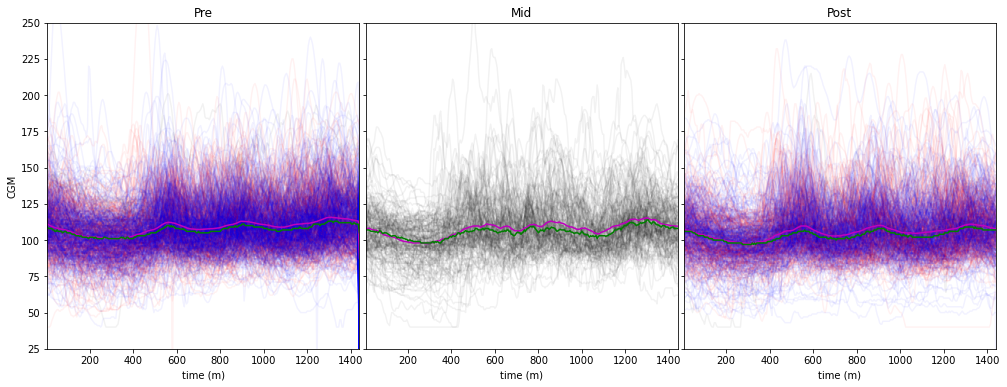

In [16]:
fig,(ax_pre,ax_mid,ax_post) = plt.subplots(1,3,figsize=(17,6),sharey=True)
fig.subplots_adjust(wspace=.02, hspace=0)

for p in participants.values():
    for study,study_key in zip(p.studies.values(),p.studies.keys()):
        #print(study,study_key)
        k1,k2 = study_key
        if k1 == 'Pre':
            if ('Pre', 'GItype') in p.features.keys() and p.features[('Pre', 'GItype')] == 'Low-GI':
                c = 'b'
            elif ('Pre', 'GItype') in p.features.keys() and p.features[('Pre', 'GItype')] == 'High-GI':
                c = 'r'
            else:
                c = 'k'
            ax_pre.plot(study.CGM_x,study.CGM_y,'-',color=c,alpha=.05)
        if k1 == 'Mid':
            if ('Mid', 'GItype') in p.features.keys() and p.features[('Mid', 'GItype')] == 'Low-GI':
                c = 'b'
            elif ('Mid', 'GItype') in p.features.keys() and p.features[('Mid', 'GItype')] == 'High-GI':
                c = 'r'
            else:
                c = 'k'
            ax_mid.plot(study.CGM_x,study.CGM_y,'-',color=c,alpha=.05)
        if k1 == 'Post':
            if ('Post', 'GItype') in p.features.keys() and p.features[('Post', 'GItype')] == 'Low-GI':
                c = 'b'
            elif ('Post', 'GItype') in p.features.keys() and p.features[('Post', 'GItype')] == 'High-GI':
                c = 'r'
            else:
                c = 'k'
            ax_post.plot(study.CGM_x,study.CGM_y,'-',color=c,alpha=.05)
            
ax_pre.plot(x_pre_mean,pre_mean,'m')
ax_mid.plot(x_mid_mean,mid_mean,'m')
ax_post.plot(x_post_mean,post_mean,'m')

ax_pre.plot(x_pre_mean,pre_median,'g')
ax_mid.plot(x_mid_mean,mid_median,'g')
ax_post.plot(x_post_mean,post_median,'g')

ax_pre.set_title("Pre")
ax_mid.set_title("Mid")
ax_post.set_title("Post")

ax_pre.set_xlabel('time (m)')
ax_mid.set_xlabel('time (m)')
ax_post.set_xlabel('time (m)')
ax_pre.set_ylabel('CGM')

ax_pre.axis([min(x_pre_mean),max(x_pre_mean),25,250])
ax_mid.axis([min(x_pre_mean),max(x_pre_mean),25,250])
ax_post.axis([min(x_pre_mean),max(x_pre_mean),25,250])

#fig.tight_layout()
#ax2.fill_between(range(len(waterfall_high)), 0, waterfall_high)
#plt.tight_layout()
plt.savefig("CGM_timeseries_GI.png",format='png', dpi=600)
plt.savefig("CGM_timeseries_GI.pdf",format='pdf')
plt.show()

In [17]:
# import R's utility package
utils = rpackages.importr('utils')

shiny_r = rpackages.importr('shiny')
DT_r = rpackages.importr('DT')
dygraphs_r = rpackages.importr('dygraphs')
ggplot2_r = rpackages.importr('ggplot2')
lubridate_r = rpackages.importr('lubridate')
xts_r = rpackages.importr('xts',on_conflict="warn")
scales_r = rpackages.importr('scales')

r = robjects.r
r['source']('shinySpecClust_mod/classify.R')

#paramF = "shinySpecClust/train.overlap_37+window_2.5.params.Rdata"
#r['load'](paramF)

#windowsF= "shinySpecClust/rawDexcomSeries+overlap_37+window_2.5+user_all"
#train_windows_r = r['fread'](windowsF)

r('''
    df_to_xts = function(df) {
    ts = xts(df[,-1], order.by=ymd_hms(df[,1]))
        return(ts)
    }
    ''')
df_to_xts_r = robjects.globalenv["df_to_xts"]

r('''
    read_cgmF = function(f) {
        df = tryCatch( {
                read.table(f, sep='\t', h=T, quote="")},
                error=function(e)
                read.table(f, sep='\t',
                        fileEncoding="UTF-16LE", h=T, quote="")
        )
        df[[1]] = ymd_hms(df[[1]])
        return (df)
}
''')

read_cgmF_r = robjects.globalenv["read_cgmF"]


/Users/tpsantos/anaconda3/envs/mlenv/lib/python3.9/site-packages/rpy2/robjects/packages_utils.py:127: UserWarning: Conflict when converting R symbols in the package "xts" to Python symbols: 
-_subset_xts -> .subset_xts, .subset.xts
  warn(msg)


In [19]:
for p in list(participants.values()):
    studies = []
    if any(p.studies):
        studies = list(set(np.array(list(p.studies.keys()))[:,0]))
    for s in studies:
        p.export_file(s)
        cgm_r = r['read_cgmF']("cgm.tsv")

        freq_r = r['classify_glucotype'](cgm_r)
        low,mod,sev = list(freq_r[0])
        print(p.ID,s,freq_r[0])
        
        p.add_feature((s,'glucotype_low'),low)
        p.add_feature((s,'glucotype_mod'),mod)
        p.add_feature((s,'glucotype_sev'),sev)
        

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
102 Pre [1] 0.1153846 0.2884615 0.5961538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
102 Mid [1] 0.0000000 0.1346154 0.8653846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
102 Post [1] 0.04615385 0.35384615 0.60000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
104 Pre [1] 0.0000000 0.8307692 0.1692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
104 Mid [1] 0.05263158 0.26315789 0.68421053

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
104 Post [1] 0.0000000 0.7384615 0.2615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
107 Pre [1] 0.08 0.32 0.60

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
107 Mid [1] 0.00 0.72 0.28

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
107 Post [1] 0.00 0.44 0.56

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
112 Pre [1] 0.01538462 0.43076923 0.55384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
117 Pre [1] 0.08695652 0.13043478 0.78260870

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
117 Mid [1] 0.0000000 0.2702703 0.7297297

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
117 Post [1] 0.0000000 0.1538462 0.8461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
118 Pre [1] 0.0000000 0.4615385 0.5384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
122 Pre [1] 0.0000000 0.4923077 0.5076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
122 Mid [1] 0.07894737 0.47368421 0.44736842

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
123 Pre [1] 0.1692308 0.6000000 0.2307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
123 Post [1] 0.1346154 0.5384615 0.3269231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
126 Pre [1] 0.00000000 0.03846154 0.96153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
130 Pre [1] 0.0000000 0.6461538 0.3538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
132 Pre [1] 0.1076923 0.7230769 0.1692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
132 Mid [1] 0.04615385 0.47692308 0.47692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
132 Post [1] 0.1384615 0.5230769 0.3384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
139 Pre [1] 0.1666667 0.5128205 0.3205128

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
139 Mid [1] 0.1692308 0.5230769 0.3076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
139 Post [1] 0.31578947 0.60526316 0.07894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
146 Pre [1] 0.01282051 0.65384615 0.33333333

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
146 Mid [1] 0.06410256 0.64102564 0.29487179

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
146 Post [1] 0.0000000 0.3333333 0.6666667

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
147 Pre [1] 0.01538462 0.15384615 0.83076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
152 Pre [1] 0.2105263 0.5789474 0.2105263

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
152 Mid [1] 0.04 0.88 0.08

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
152 Post [1] 0.04 0.84 0.12

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
153 Pre [1] 0.0000000 0.4615385 0.5384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
153 Mid [1] 0.0000000 0.2307692 0.7692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
154 Pre [1] 0.00 0.04 0.96

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
154 Mid [1] 0.0000000 0.3333333 0.6666667

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
154 Post [1] 0.00000000 0.02631579 0.97368421

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
163 Pre [1] 0.0000000 0.1578947 0.8421053

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
163 Mid [1] 0.07692308 0.34615385 0.57692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
163 Post [1] 0.05263158 0.23684211 0.71052632

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
165 Pre [1] 0.0000000 0.4230769 0.5769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
165 Mid [1] 0.0000000 0.4166667 0.5833333

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
165 Post [1] 0.1346154 0.6153846 0.2500000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
170 Pre [1] 0.01538462 0.69230769 0.29230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
170 Mid [1] 0.01538462 0.55384615 0.43076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
170 Post [1] 0.38461538 0.52307692 0.09230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
172 Pre [1] 0.00000000 0.03846154 0.96153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
173 Pre [1] 0.1730769 0.5961538 0.2307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
175 Pre [1] 0.00000000 0.09615385 0.90384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
175 Mid [1] 0.00000000 0.07692308 0.92307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
175 Post [1] 0.07692308 0.07692308 0.84615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
177 Pre [1] 0.0000000 0.3421053 0.6578947

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
177 Mid [1] 0.1025641 0.3846154 0.5128205

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
178 Pre [1] 0.0000000 0.4423077 0.5576923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
181 Pre [1] 0.0 0.6 0.4

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
181 Mid [1] 0.29230769 0.61538462 0.09230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
181 Post [1] 0.1025641 0.4871795 0.4102564

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
503 Pre [1] 0.03076923 0.41538462 0.55384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
503 Post [1] 0.02631579 0.39473684 0.57894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
504 Pre [1] 0.0000000 0.1346154 0.8653846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
505 Pre [1] 0.0 0.5 0.5

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
508 Pre [1] 0.1315789 0.6315789 0.2368421

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
510 Pre [1] 0.01282051 0.25641026 0.73076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
514 Pre [1] 0.01538462 0.41538462 0.56923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
514 Post [1] 0.00 0.25 0.75

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
518 Pre [1] 0.2000000 0.3846154 0.4153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
518 Post [1] 0.07692308 0.61538462 0.30769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
519 Pre [1] 0.01923077 0.17307692 0.80769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
519 Post [1] 0.0000000 0.1315789 0.8684211

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
521 Pre [1] 0.04615385 0.36923077 0.58461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
521 Post [1] 0.04615385 0.66153846 0.29230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
523 Pre [1] 0.06153846 0.09230769 0.84615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
525 Pre [1] 0.02564103 0.44871795 0.52564103

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
526 Pre [1] 0.00 0.08 0.92

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
526 Post [1] 0.0000000 0.1315789 0.8684211

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
532 Pre [1] 0.00000000 0.05128205 0.94871795

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
533 Pre [1] 0.07894737 0.00000000 0.92105263

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
535 Pre [1] 0.01538462 0.49230769 0.49230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
536 Pre [1] 0.03846154 0.61538462 0.34615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
539 Pre [1] 0.01282051 0.21794872 0.76923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
539 Post [1] 0.0000000 0.1923077 0.8076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
540 Pre [1] 0.0000000 0.5192308 0.4807692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
540 Post [1] 0.0000000 0.3974359 0.6025641

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
542 Pre [1] 0.1384615 0.5384615 0.3230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
542 Post [1] 0.08974359 0.50000000 0.41025641

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
544 Pre [1] 0.07894737 0.44736842 0.47368421

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
544 Post [1] 0.1230769 0.4307692 0.4461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
546 Pre [1] 0.0000000 0.6461538 0.3538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
546 Post [1] 0.01538462 0.72307692 0.26153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
550 Pre [1] 0.0000000 0.7820513 0.2179487

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
550 Post [1] 0.06153846 0.72307692 0.21538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
552 Pre [1] 0.0000000 0.3692308 0.6307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
552 Post [1] 0.0000000 0.6615385 0.3384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
554 Pre [1] 0.0000000 0.2307692 0.7692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
554 Post [1] 0.0000000 0.5526316 0.4473684

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
556 Pre [1] 0.08974359 0.53846154 0.37179487

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
556 Post [1] 0.05128205 0.42307692 0.52564103

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
558 Pre [1] 0.05128205 0.30769231 0.64102564

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
558 Post [1] 0.05128205 0.67948718 0.26923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
560 Pre [1] 0.01282051 0.05128205 0.93589744

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
560 Post [1] 0.0000000 0.1076923 0.8923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
562 Pre [1] 0.33333333 0.08333333 0.58333333

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
562 Post [1] 0.0000000 0.5833333 0.4166667

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
564 Pre [1] 0.0000000 0.2884615 0.7115385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
564 Post [1] 0.1282051 0.5000000 0.3717949

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
566 Pre [1] 0.0000000 0.2461538 0.7538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
569 Pre [1] 0.01538462 0.21538462 0.76923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
571 Pre [1] 0.08 0.24 0.68

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
571 Post [1] 0.25000000 0.66666667 0.08333333

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
572 Pre [1] 0.00000000 0.06410256 0.93589744

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
572 Post [1] 0.0000000 0.1923077 0.8076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
573 Pre [1] 0.06153846 0.44615385 0.49230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
573 Post [1] 0.06410256 0.70512821 0.23076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
575 Pre [1] 0.05263158 0.26315789 0.68421053

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
575 Post [1] 0.01923077 0.71153846 0.26923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
301 Pre [1] 0.0000000 0.2307692 0.7692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
301 Post [1] 0.0000000 0.5192308 0.4807692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
303 Pre [1] 0.0000000 0.5230769 0.4769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
303 Post [1] 0.01538462 0.29230769 0.69230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
310 Pre [1] 0.04 0.64 0.32

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
311 Pre [1] 0.0000000 0.6346154 0.3653846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
312 Pre [1] 0.07692308 0.48076923 0.44230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
313 Pre [1] 0.0000000 0.4473684 0.5526316

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
313 Post [1] 0.24615385 0.70769231 0.04615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
314 Pre [1] 0.0 0.6 0.4

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
315 Pre [1] 0.40000000 0.53846154 0.06153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
315 Post [1] 0.1923077 0.4038462 0.4038462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
316 Pre [1] 0.03076923 0.66153846 0.30769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
316 Post [1] 0.0000000 0.4423077 0.5576923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
317 Pre [1] 0.0000000 0.3269231 0.6730769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
317 Post [1] 0.2115385 0.6730769 0.1153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
321 Pre [1] 0.1076923 0.4307692 0.4615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
321 Post [1] 0.1153846 0.4807692 0.4038462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
322 Pre [1] 0.0000000 0.2307692 0.7692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
322 Post [1] 0.05769231 0.59615385 0.34615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
324 Pre [1] 0.0000000 0.7076923 0.2923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
324 Post [1] 0.3421053 0.6578947 0.0000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
328 Pre [1] 0.13461538 0.78846154 0.07692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
328 Post [1] 0.0000000 0.5961538 0.4038462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
329 Pre [1] 0.6923077 0.3076923 0.0000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
329 Post [1] 0.06153846 0.90769231 0.03076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
334 Pre [1] 0.19230769 0.76923077 0.03846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
334 Post [1] 0.60000000 0.32307692 0.07692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
335 Pre [1] 0.11538462 0.80769231 0.07692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
335 Post [1] 0.03076923 0.90769231 0.06153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
338 Pre [1] 0.2884615 0.5576923 0.1538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
338 Post [1] 0.04615385 0.69230769 0.26153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
342 Pre [1] 0.0000000 0.5538462 0.4461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
342 Post [1] 0.0000000 0.8421053 0.1578947

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
345 Pre [1] 0.06153846 0.29230769 0.64615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
345 Post [1] 0.1578947 0.5526316 0.2894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
348 Pre [1] 0.00000000 0.92105263 0.07894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
348 Post [1] 0.13461538 0.84615385 0.01923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
351 Pre [1] 0.03076923 0.52307692 0.44615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
351 Post [1] 0.04615385 0.89230769 0.06153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
354 Pre [1] 0.07692308 0.59615385 0.32692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
354 Post [1] 0.01923077 0.65384615 0.32692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
103 Pre [1] 0.09230769 0.61538462 0.29230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
105 Pre [1] 0.01538462 0.10769231 0.87692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
105 Mid [1] 0.01923077 0.32692308 0.65384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
108 Pre [1] 0.03076923 0.09230769 0.87692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
108 Mid [1] 0.0000000 0.2105263 0.7894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
108 Post [1] 0.0000000 0.2105263 0.7894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
109 Pre [1] 0.09230769 0.35384615 0.55384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
109 Mid [1] 0.01923077 0.34615385 0.63461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
109 Post [1] 0.04615385 0.38461538 0.56923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
110 Pre [1] 0.2894737 0.5789474 0.1315789

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
110 Mid [1] 0.2000000 0.6307692 0.1692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
110 Post [1] 0 1 0

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
114 Pre [1] 0.03076923 0.35384615 0.61538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
114 Mid [1] 0.0 0.6 0.4

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
114 Post [1] 0.04761905 0.60317460 0.34920635

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
115 Pre [1] 0.01538462 0.44615385 0.53846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
115 Mid [1] 0.0 0.6 0.4

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
115 Post [1] 0.01538462 0.43076923 0.55384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
119 Pre [1] 0.1315789 0.1315789 0.7368421

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
119 Mid [1] 0.00000000 0.08974359 0.91025641

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
119 Post [1] 0.09615385 0.32692308 0.57692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
120 Pre [1] 0.01538462 0.13846154 0.84615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
120 Mid [1] 0.1052632 0.1842105 0.7105263

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
121 Pre [1] 0.00000000 0.02631579 0.97368421

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
121 Post [1] 0.00000000 0.03846154 0.96153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
124 Pre [1] 0.01538462 0.66153846 0.32307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
124 Mid [1] 0.1153846 0.5384615 0.3461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
124 Post [1] 0.1692308 0.6923077 0.1384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
128 Pre [1] 0.0000000 0.4230769 0.5769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
128 Mid [1] 0.0000000 0.4923077 0.5076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
128 Post [1] 0.41025641 0.55128205 0.03846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
131 Pre [1] 0.0000000 0.3076923 0.6923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
131 Mid [1] 0.13846154 0.81538462 0.04615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
131 Post [1] 0.07692308 0.41538462 0.50769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
133 Pre [1] 0.06153846 0.36923077 0.56923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
133 Mid [1] 0.08974359 0.62820513 0.28205128

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
133 Post [1] 0.06153846 0.36923077 0.56923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
136 Pre [1] 0.07692308 0.40000000 0.52307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
136 Mid [1] 0.2307692 0.4307692 0.3384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
136 Post [1] 0.1692308 0.5692308 0.2615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
137 Pre [1] 0.04615385 0.35384615 0.60000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
137 Mid [1] 0.01538462 0.66153846 0.32307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
137 Post [1] 0.1230769 0.6615385 0.2153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
151 Pre [1] 0.01538462 0.58461538 0.40000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
155 Pre [1] 0.06410256 0.56410256 0.37179487

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
155 Post [1] 1 0 0

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
164 Pre [1] 0.0000000 0.2615385 0.7384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
164 Mid [1] 0.1076923 0.2615385 0.6307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
167 Pre [1] 0.09230769 0.81538462 0.09230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
167 Mid [1] 0.0 0.8 0.2

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
169 Pre [1] 0.0000000 0.3421053 0.6578947

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
169 Post [1] 0.02631579 0.36842105 0.60526316

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
171 Pre [1] 0.06153846 0.32307692 0.61538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
179 Pre [1] 0.07692308 0.87692308 0.04615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
180 Pre [1] 0.02631579 0.60526316 0.36842105

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
180 Post [1] 0.07894737 0.68421053 0.23684211

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
501 Pre [1] 0.0000000 0.1346154 0.8653846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
502 Pre [1] 0.00000000 0.01538462 0.98461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
506 Pre [1] 0.07894737 0.28947368 0.63157895

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
506 Post [1] 0.0000000 0.3653846 0.6346154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
507 Pre [1] 0.07894737 0.50000000 0.42105263

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
507 Post [1] 0.02631579 0.39473684 0.57894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
511 Pre [1] 0.09230769 0.24615385 0.66153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
513 Pre [1] 0.04 0.28 0.68

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
513 Post [1] 0.00 0.12 0.88

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
515 Pre [1] 0.01538462 0.18461538 0.80000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
515 Post [1] 0.0000000 0.1666667 0.8333333

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
516 Pre [1] 0.0000000 0.1384615 0.8615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
517 Pre [1] 0.09230769 0.60000000 0.30769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
517 Post [1] 0.000000 0.525641 0.474359

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
520 Pre [1] 0.0000000 0.1538462 0.8461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
520 Post [1] 0.0000000 0.3333333 0.6666667

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
527 Pre [1] 0.0000000 0.2179487 0.7820513

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
528 Pre [1] 0.01538462 0.27692308 0.70769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
528 Post [1] 0.0000000 0.2923077 0.7076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
530 Pre [1] 0.07692308 0.24615385 0.67692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
531 Pre [1] 0.06153846 0.16923077 0.76923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
534 Pre [1] 0.01282051 0.84615385 0.14102564

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
534 Post [1] 0.0000000 0.6538462 0.3461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
537 Pre [1] 0.01282051 0.55128205 0.43589744

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
537 Post [1] 0.07894737 0.76315789 0.15789474

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
538 Pre [1] 0.0000000 0.2948718 0.7051282

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
541 Pre [1] 0.0000000 0.6153846 0.3846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
541 Post [1] 0.04 0.84 0.12

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
543 Pre [1] 0 0 1

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
543 Post [1] 0.03846154 0.05769231 0.90384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
545 Pre [1] 0.08333333 0.33333333 0.58333333

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
545 Post [1] 0.03846154 0.23076923 0.73076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
547 Pre [1] 0.04615385 0.13846154 0.81538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
547 Post [1] 0.0000000 0.5769231 0.4230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
548 Pre [1] 0.2500000 0.3461538 0.4038462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
548 Post [1] 0.0000000 0.2051282 0.7948718

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
549 Pre [1] 0.1538462 0.6025641 0.2435897

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
549 Post [1] 0.07692308 0.59615385 0.32692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
551 Pre [1] 0.2000000 0.4461538 0.3538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
551 Post [1] 0.09615385 0.61538462 0.28846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
553 Pre [1] 0.0000000 0.4461538 0.5538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
553 Post [1] 0.01282051 0.71794872 0.26923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
555 Pre [1] 0.02564103 0.62820513 0.34615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
555 Post [1] 0.0000000 0.8461538 0.1538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
557 Pre [1] 0.1025641 0.5769231 0.3205128

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
557 Post [1] 0.03076923 0.73846154 0.23076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
559 Pre [1] 0.01282051 0.10256410 0.88461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
559 Post [1] 0.05128205 0.37179487 0.57692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
561 Pre [1] 0.0000000 0.1730769 0.8269231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
561 Post [1] 0.07692308 0.44615385 0.47692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
563 Pre [1] 0.07692308 0.67948718 0.24358974

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
563 Post [1] 0.1666667 0.7051282 0.1282051

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
565 Pre [1] 0.1076923 0.3692308 0.5230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
565 Post [1] 0.05128205 0.53846154 0.41025641

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
567 Pre [1] 0.03846154 0.55128205 0.41025641

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
567 Post [1] 0.05769231 0.38461538 0.55769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
568 Pre [1] 0.1730769 0.5576923 0.2692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
568 Post [1] 0.06153846 0.58461538 0.35384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
574 Pre [1] 0.0000000 0.1730769 0.8269231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
574 Post [1] 0.0000000 0.2153846 0.7846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
576 Pre [1] 0.1076923 0.4153846 0.4769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
576 Post [1] 0.000000 0.474359 0.525641

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
304 Pre [1] 0.1692308 0.3846154 0.4461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
304 Post [1] 0.0000000 0.1538462 0.8461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
305 Pre [1] 0.0000000 0.4615385 0.5384615

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
305 Post [1] 0.16923077 0.78461538 0.04615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
306 Pre [1] 0.03076923 0.70769231 0.26153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
307 Pre [1] 0.05769231 0.36538462 0.57692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
307 Post [1] 0.1692308 0.4769231 0.3538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
308 Pre [1] 0.0 0.4 0.6

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
308 Post [1] 0.0000000 0.4153846 0.5846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
318 Pre [1] 0.0000000 0.8461538 0.1538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
318 Post [1] 0.04615385 0.93846154 0.01538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
319 Pre [1] 0.1076923 0.6769231 0.2153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
319 Post [1] 0.12307692 0.86153846 0.01538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
320 Pre [1] 0.2 0.8 0.0

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
320 Post [1] 0.52307692 0.41538462 0.06153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
323 Pre [1] 0.2153846 0.5692308 0.2153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
323 Post [1] 0.2307692 0.6153846 0.1538462

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
325 Pre [1] 0.19230769 0.78846154 0.01923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
325 Post [1] 0.42307692 0.55769231 0.01923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
326 Pre [1] 0.09615385 0.57692308 0.32692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
326 Post [1] 0.01923077 0.50000000 0.48076923

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
327 Pre [1] 0.02631579 0.47368421 0.50000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
327 Post [1] 0.00000000 0.03846154 0.96153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
330 Pre [1] 0.06153846 0.60000000 0.33846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
330 Post [1] 0.1230769 0.6153846 0.2615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
331 Pre [1] 0.01923077 0.71153846 0.26923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
331 Post [1] 0.1153846 0.6538462 0.2307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
332 Pre [1] 0.00 0.84 0.16

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
332 Post [1] 0.03846154 0.69230769 0.26923077

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
333 Pre [1] 0.0000000 0.5769231 0.4230769

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
333 Post [1] 0.2105263 0.5789474 0.2105263

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
336 Pre [1] 0.00000000 0.05263158 0.94736842

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
336 Post [1] 0.0000000 0.4807692 0.5192308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
337 Pre [1] 0.0000000 0.5384615 0.4615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
337 Post [1] 0.0 0.5 0.5

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
339 Pre [1] 0.16923077 0.76923077 0.06153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
339 Post [1] 0.0000000 0.6578947 0.3421053

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
340 Pre [1] 0.03076923 0.52307692 0.44615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
340 Post [1] 0.1315789 0.5789474 0.2894737

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
343 Pre [1] 0.0000000 0.6578947 0.3421053

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
344 Pre [1] 0.0000000 0.5230769 0.4769231

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
344 Post [1] 0.0000000 0.6346154 0.3653846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
346 Pre [1] 0.7368421 0.2631579 0.0000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
347 Pre [1] 0.01923077 0.51923077 0.46153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
347 Post [1] 0.06153846 0.80000000 0.13846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
352 Pre [1] 0.01923077 0.40384615 0.57692308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
352 Post [1] 0.0000000 0.4807692 0.5192308

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
353 Pre [1] 0.03846154 0.67307692 0.28846154

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
353 Post [1] 0.0 0.5 0.5

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
125 Mid [1] 0.07692308 0.53846154 0.38461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
125 Post [1] 0.1578947 0.5263158 0.3157895

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
157 Mid [1] 0.00 0.56 0.44

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
157 Post [1] 0.04615385 0.50769231 0.44615385

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
158 Mid [1] 0.08 0.36 0.56

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
158 Post [1] 0.01538462 0.38461538 0.60000000

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
129 Mid [1] 0.00000000 0.06410256 0.93589744

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
129 Post [1] 0.0000000 0.5538462 0.4461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
148 Mid [1] 0.0000000 0.5192308 0.4807692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
159 Mid [1] 0.0000000 0.3692308 0.6307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
159 Post [1] 0.1153846 0.5384615 0.3461538

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
160 Mid [1] 0.06410256 0.75641026 0.17948718

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
160 Post [1] 0.1923077 0.5897436 0.2179487

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
529 Post [1] 0.0000000 0.2692308 0.7307692

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
341 Post [1] 0.15789474 0.81578947 0.02631579

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
355 Post [1] 0.0000000 0.8421053 0.1578947

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
127 Post [1] 0.0000000 0.5846154 0.4153846

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
174 Post [1] 0.0000000 0.6052632 0.3947368

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
309 Post [1] 0.05263158 0.60526316 0.34210526



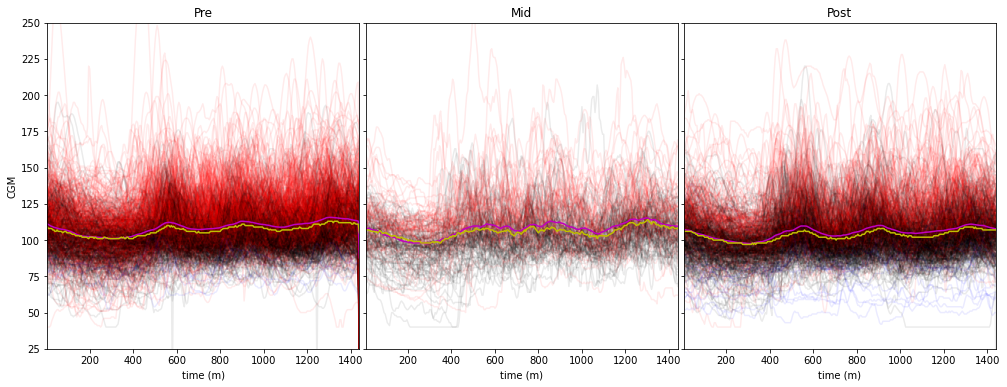

In [20]:
fig,(ax_pre,ax_mid,ax_post) = plt.subplots(1,3,figsize=(17,6),sharey=True)
fig.subplots_adjust(wspace=.02, hspace=0)

colors = ['b','k','r']

for p in participants.values():
    for study,study_key in zip(p.studies.values(),p.studies.keys()):
        #print(study,study_key)
        k1,k2 = study_key
        if k1 == 'Pre':
            if ('Pre', 'glucotype_low') in p.features.keys():
                low = p.features[('Pre','glucotype_low')]
                mod = p.features[('Pre','glucotype_mod')]
                sev = p.features[('Pre','glucotype_sev')]
                idx = np.argmax([low,mod,sev])
            ax_pre.plot(study.CGM_x,study.CGM_y,'-',c=colors[idx],alpha=.08)
        if k1 == 'Mid':
            if ('Mid', 'glucotype_low') in p.features.keys():
                low = p.features[('Mid','glucotype_low')]
                mod = p.features[('Mid','glucotype_mod')]
                sev = p.features[('Mid','glucotype_sev')]
                idx = np.argmax([low,mod,sev])
            ax_mid.plot(study.CGM_x,study.CGM_y,'-',c=colors[idx],alpha=.08)
        if k1 == 'Post':
            if ('Post', 'glucotype_low') in p.features.keys():
                low = p.features[('Post','glucotype_low')]
                mod = p.features[('Post','glucotype_mod')]
                sev = p.features[('Post','glucotype_sev')]
                idx = np.argmax([low,mod,sev])
            ax_post.plot(study.CGM_x,study.CGM_y,'-',c=colors[idx],alpha=.08)
            
ax_pre.plot(x_pre_mean,pre_mean,'m')
ax_mid.plot(x_mid_mean,mid_mean,'m')
ax_post.plot(x_post_mean,post_mean,'m')

ax_pre.plot(x_pre_mean,pre_median,'y')
ax_mid.plot(x_mid_mean,mid_median,'y')
ax_post.plot(x_post_mean,post_median,'y')

ax_pre.set_title("Pre")
ax_mid.set_title("Mid")
ax_post.set_title("Post")

ax_pre.set_xlabel('time (m)')
ax_mid.set_xlabel('time (m)')
ax_post.set_xlabel('time (m)')
ax_pre.set_ylabel('CGM')

ax_pre.axis([min(x_pre_mean),max(x_pre_mean),25,250])
ax_mid.axis([min(x_pre_mean),max(x_pre_mean),25,250])
ax_post.axis([min(x_pre_mean),max(x_pre_mean),25,250])

#fig.tight_layout()
#ax2.fill_between(range(len(waterfall_high)), 0, waterfall_high)
#plt.tight_layout()
#plt.savefig("CGM_timeseries_GI.png",format='png', dpi=600)
#plt.savefig("CGM_timeseries_GI.pdf",format='pdf')
plt.show()

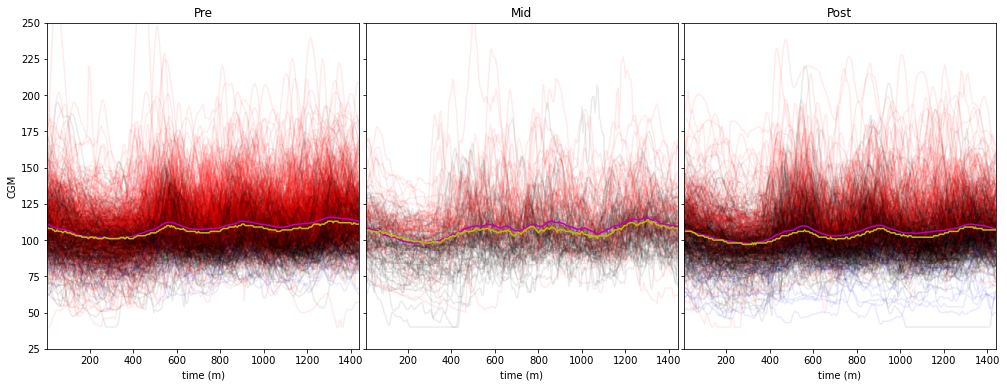

In [153]:
#

[[[ 81.70601852 101.65019139 114.66358212]
  [ 73.39869792 100.2671751  114.65081765]]

 [[ 81.25434028 101.73460047 114.34362341]
  [ 88.29947917 100.0705691  116.25391174]]]


<ipython-input-102-b910a40cc33c>:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_low.show()
<ipython-input-102-b910a40cc33c>:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_high.show()


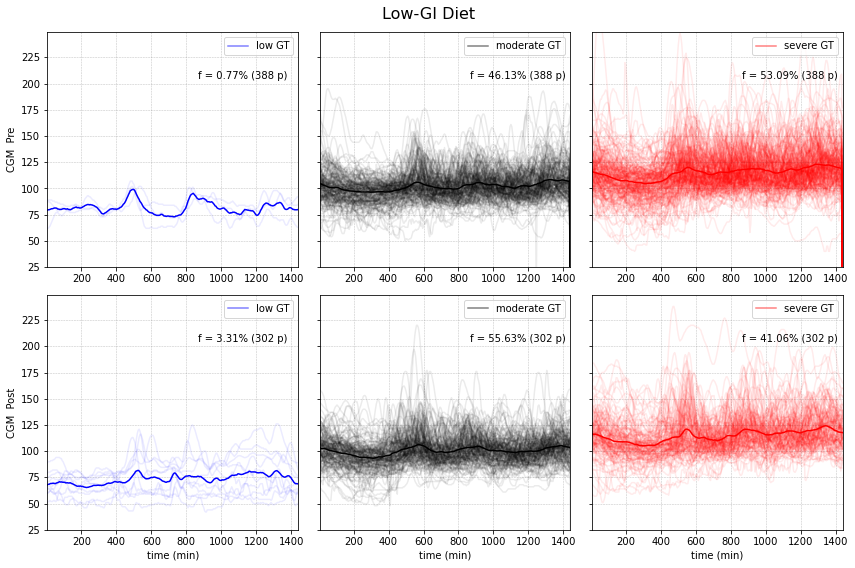

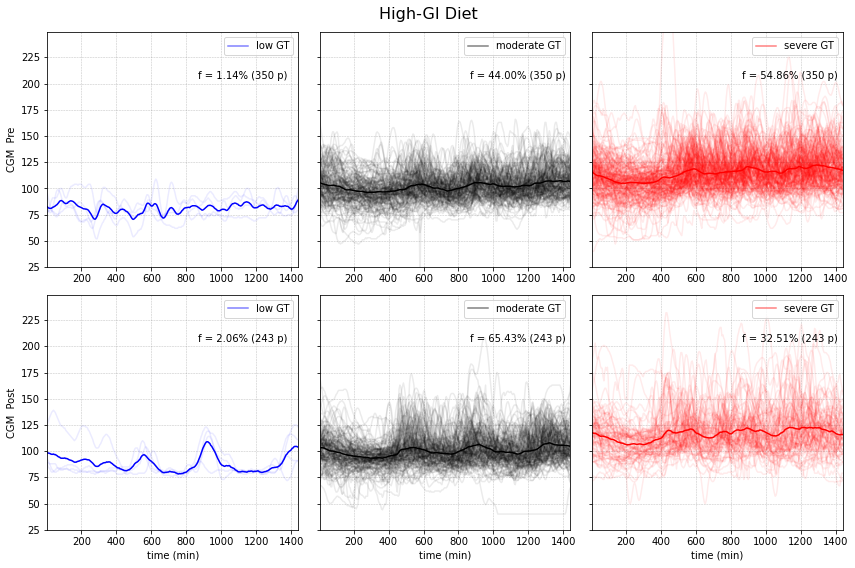

In [102]:
fig_low,ax_low = plt.subplots(2,3,figsize=(12,8),sharey=True) #(ax_pre_lowGI, ax_post_lowGI)
fig_low.subplots_adjust(wspace=.01, hspace=0)
fig_low.suptitle('Low-GI Diet', fontsize=16)

fig_high,ax_high = plt.subplots(2,3,figsize=(12,8),sharey=True) #(ax_pre_highGI, ax_post_highGI)
fig_high.subplots_adjust(wspace=.01, hspace=0)
fig_high.suptitle('High-GI Diet', fontsize=16)

colors = ['b','k','r']
glucotypes = ['glucotype_low','glucotype_mod','glucotype_sev']

alpha_label = 0.5
xlabel = 'time (min)'
min_y = 25
max_y=249
linewidth = 0.5
loc = "upper right"
labels = ['low GT','moderate GT','severe GT']

ax_low[0][0].set_ylabel('CGM  Pre')
ax_low[1][0].set_ylabel('CGM  Post')
ax_high[0][0].set_ylabel('CGM  Pre')
ax_high[1][0].set_ylabel('CGM  Post')
    
for gt in range(3):
    
    ax_low[1][gt].set_xlabel(xlabel)
    ax_high[1][gt].set_xlabel(xlabel)
    
    for ax in [*ax_low,*ax_high]:

        ax[gt].plot([],[],c=colors[gt],alpha=alpha_label,label=labels[gt])
        ax[gt].axis([min(x_pre_mean),max(x_pre_mean),min_y,max_y])
        ax[gt].grid(alpha=.5,color = 'gray', linestyle = '--', linewidth = linewidth)
        ax[gt].legend(loc=loc)

count = np.zeros(shape=(2,2,3))
sum_ = np.zeros(shape=(2,2,3,288))
mean_ = np.zeros(shape=(2,2,3))

for p in list(participants.values()):
    for study,study_key in zip(p.studies.values(),p.studies.keys()):
        #print(study,study_key)
        k1,k2 = study_key
        for num,st in enumerate(['Pre','Post']):
            for num_gi,(gi,ax) in enumerate(zip(['Low-GI','High-GI'],[ax_low,ax_high])):
                if k1 == st:
                    if ('Pre', 'glucotype_low') in p.features.keys() and (st, 'GItype') in p.features.keys() and p.features[(st, 'GItype')] == gi:
                        idx = np.argmax([p.features[(st,glu)] for glu in glucotypes])
                        count[num_gi,num,idx]+=1
                        sum_[num_gi,num,idx,:]+=study.CGM_y
                        ax[num][idx].plot(study.CGM_x,study.CGM_y,'-',c=colors[idx],alpha=.08)

for num in range(2):
    for idx in range(3):
        for num_gi,ax in enumerate([ax_low,ax_high]):
            meani = sum_[num_gi,num,idx,:]/count[num_gi,num,idx]
            mean_[num_gi,num,idx] = np.mean(meani)
            ax[num][idx].plot(study.CGM_x,meani,c=colors[idx])
            ax[num][idx].text(0.6,0.8,"f = {0:.2f}% ({1:d} p)".format(
                count[num_gi,num,idx]*100/np.sum(count[num_gi,num,:]),
                int(np.sum(count[num_gi,num,:]))),
                transform = ax[num][idx].transAxes)
            
print(mean_)

fig_low.tight_layout()
fig_high.tight_layout()
#ax2.fill_between(range(len(waterfall_high)), 0, waterfall_high)
#plt.tight_layout()
fig_low.savefig("glucotype_lowGI.pdf",format='pdf', dpi=600)
fig_high.savefig("glucotype_highGI.pdf",format='pdf',dpi=600)
fig_low.show()
fig_high.show()

In [ ]:
#### Add proportion of individuals per figure
#### Add Low GI and High GI labels
### Add mean and median

In [ ]:
'GLU_0M','INS_0M','whole_minAUC_GLU','whole_min_AVG_GLU','whole_minAUC_INS','whole_min_AVG_INS','lunch_minAUC','BREAKFAST_min_ave','breakfast_minAUC'

(160, 9)
(0,)
(131, 9)


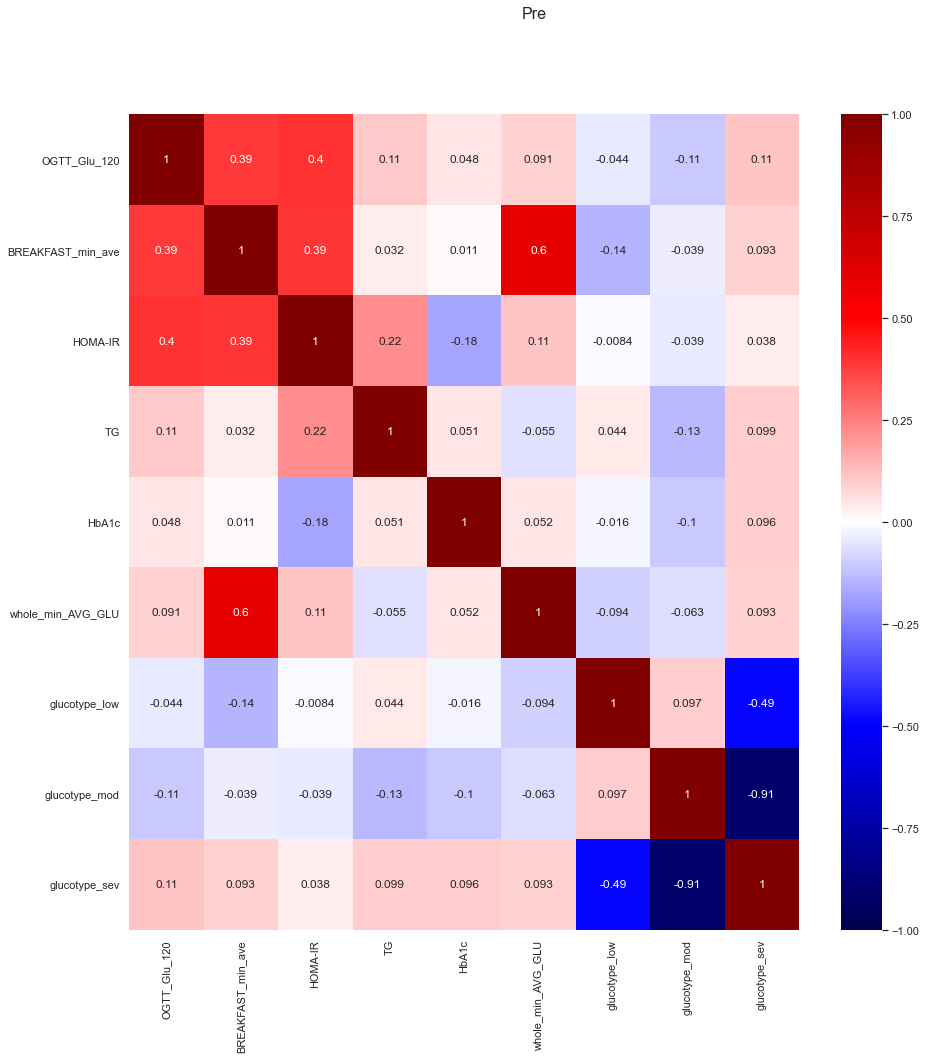

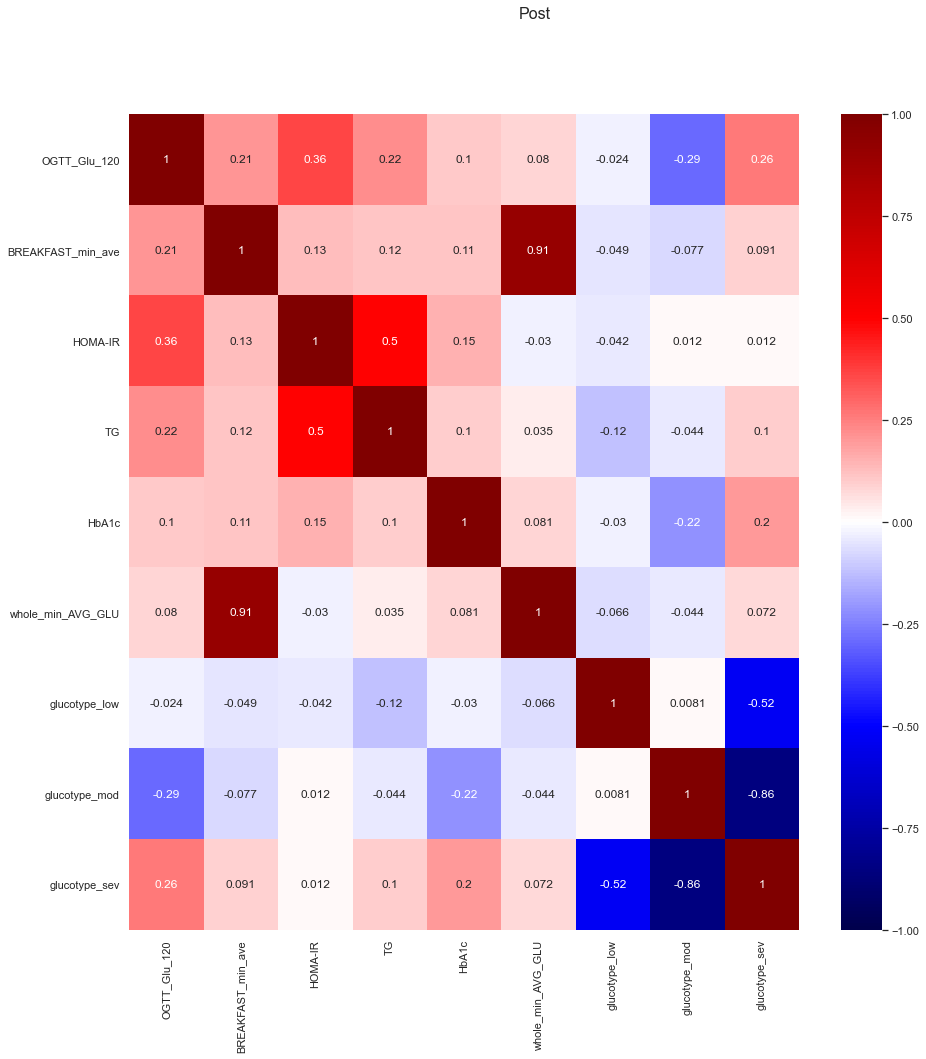

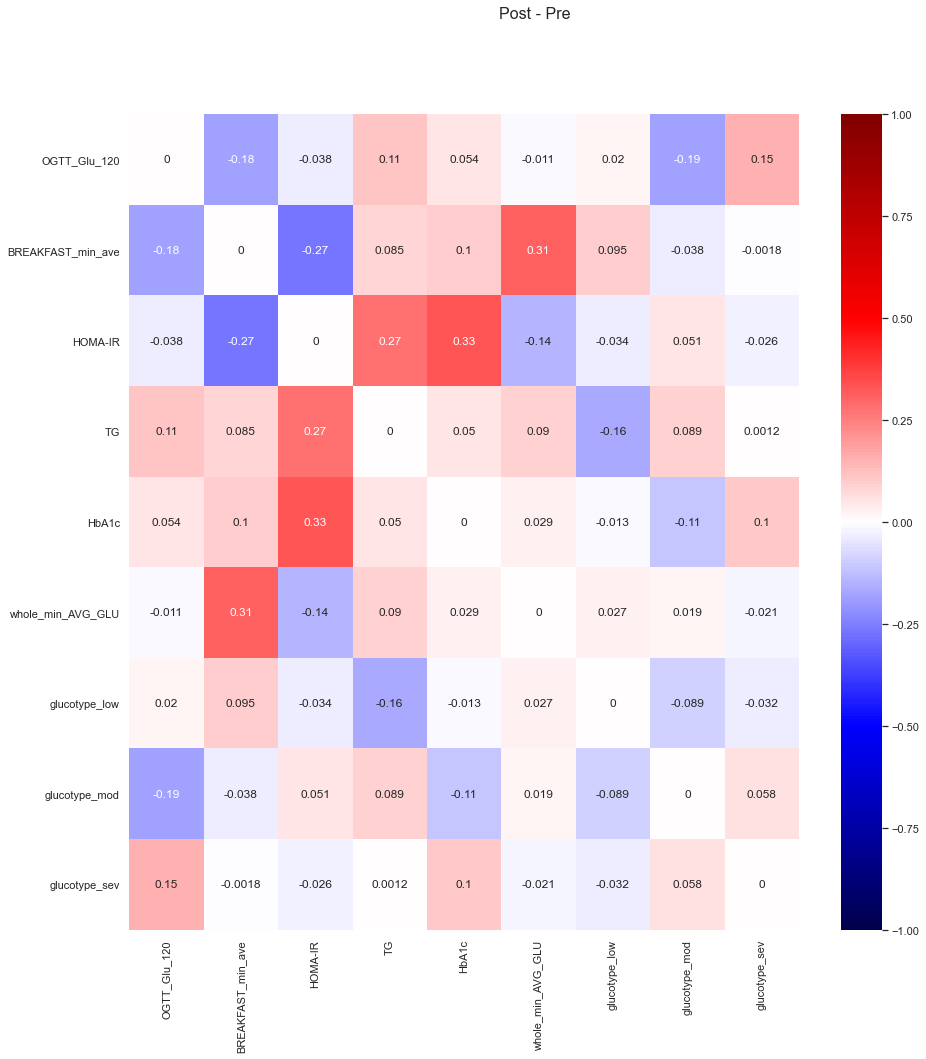

In [191]:
params = ['OGTT_Glu_120','BREAKFAST_min_ave','HOMA-IR','TG','HbA1c','whole_min_AVG_GLU','glucotype_low','glucotype_mod','glucotype_sev']


table_pre = [] #np.zeros(shape = (len(participants.values()),len(params)))
table_mid = []
table_post = []

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Pre', par) in p.features.keys():
            #print(p.ID,p.features[('Pre',par)],par)
            params_vals.append(p.features[('Pre',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_pre.append(params_vals)
table_pre = np.array(table_pre)
print(table_pre.shape)

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Mid', par) in p.features.keys():
            params_vals.append(p.features[('Mid',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_pre.append(params_vals)
table_mid = np.array(table_mid)
print(table_mid.shape)

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Post', par) in p.features.keys():
            params_vals.append(p.features[('Post',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_post.append(params_vals)
table_post = np.array(table_post)
print(table_post.shape)

df_pre = pd.DataFrame(table_pre, columns = params).replace('.',0).astype(float)
corr_pre = df_pre.corr(method='pearson')

fig,ax = plt.subplots(figsize=(15,15))
fig.suptitle('Pre',fontsize=16)
sns.heatmap(corr_pre, annot=True,cmap='seismic',vmin=-1,vmax=1)
plt.show()

df_post = pd.DataFrame(table_post, columns = params).replace('.',0).astype(float)
corr_post = df_post.corr(method='pearson')

fig,ax = plt.subplots(figsize=(15,15))
fig.suptitle('Post',fontsize=16)
sns.heatmap(corr_post, annot=True,cmap='seismic',vmin=-1,vmax=1)
plt.show()

fig,ax = plt.subplots(figsize=(15,15))
fig.suptitle('Post - Pre',fontsize=16)
sns.heatmap(corr_post-corr_pre, annot=True,cmap='seismic',vmin=-1,vmax=1)
plt.show()


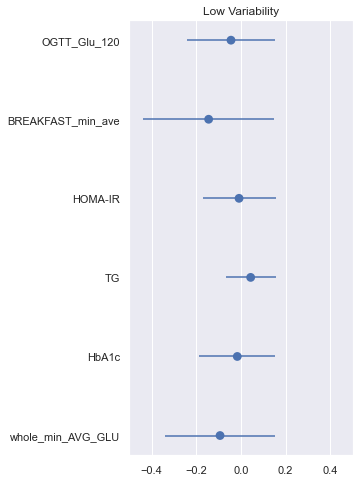

In [179]:
fig,ax = plt.subplots(figsize=(4,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_pre.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_pre['glucotype_low'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_low = []
lower_low = []
upper_low = []

for col in df_pre.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_pre[col],df_pre['glucotype_low'],alpha=0.05)
    lower_low.append(lo)
    upper_low.append(hi)
    pearson_low.append(r)

ax.set_title("Low Variability")
ax.errorbar(pearson_low, y_coords, xerr=np.array([lower_low,lower_low]),fmt=' ')
ax.set_xlim([-.5,.5])
plt.show()

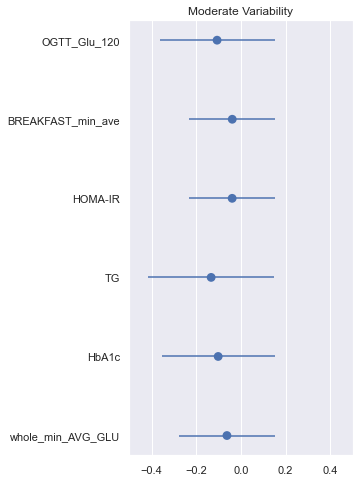

In [180]:
fig,ax = plt.subplots(figsize=(4,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_pre.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_pre['glucotype_mod'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_mod = []
lower_mod = []
upper_mod = []

for col in df_pre.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_pre[col],df_pre['glucotype_mod'],alpha=0.05)
    lower_mod.append(lo)
    upper_mod.append(hi)
    pearson_mod.append(r)

ax.set_title("Moderate Variability")
ax.errorbar(pearson_mod, y_coords, xerr=np.array([lower_mod,lower_mod]),fmt=' ')
ax.set_xlim([-.5,.5])
plt.show()

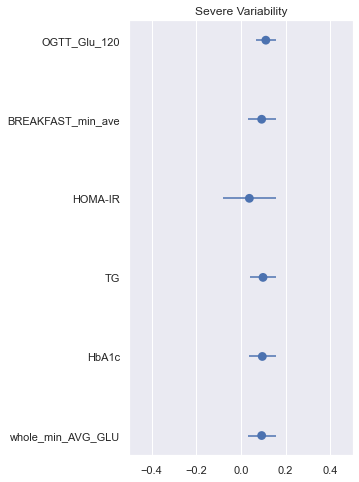

In [181]:
fig,ax = plt.subplots(figsize=(4,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_pre.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_pre['glucotype_sev'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_sev = []
lower_sev = []
upper_sev = []

for col in df_pre.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_pre[col],df_pre['glucotype_sev'],alpha=0.05)
    lower_sev.append(lo)
    upper_sev.append(hi)
    pearson_sev.append(r)

ax.set_title("Severe Variability")
ax.errorbar(pearson_sev, y_coords, xerr=np.array([lower_sev,lower_sev]),fmt=' ')
ax.set_xlim([-.5,.5])
plt.show()

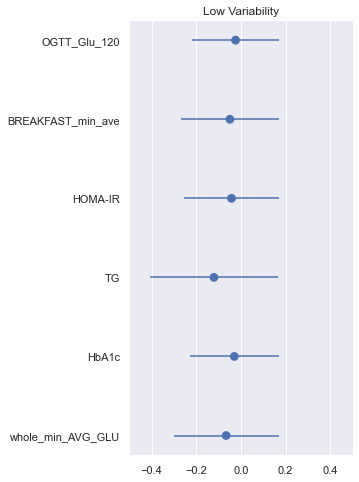

In [182]:
fig,ax = plt.subplots(figsize=(4,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_post.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_post['glucotype_low'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_low = []
lower_low = []
upper_low = []

for col in df_post.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_post[col],df_post['glucotype_low'],alpha=0.05)
    lower_low.append(lo)
    upper_low.append(hi)
    pearson_low.append(r)

ax.set_title("Low Variability")
ax.errorbar(pearson_low, y_coords, xerr=np.array([lower_low,lower_low]),fmt=' ')
ax.set_xlim([-.5,.5])
plt.show()

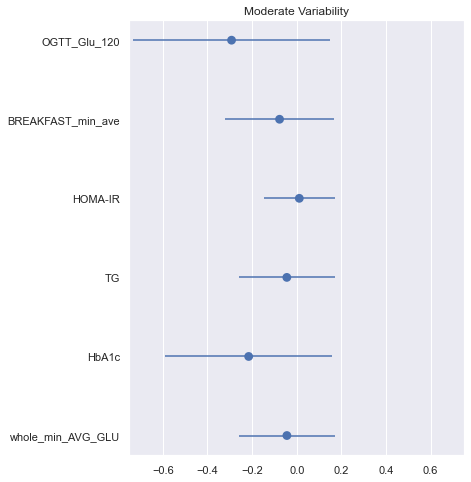

In [185]:
fig,ax = plt.subplots(figsize=(6,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_post.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_post['glucotype_mod'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_mod = []
lower_mod = []
upper_mod = []

for col in df_post.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_post[col],df_post['glucotype_mod'],alpha=0.05)
    lower_mod.append(lo)
    upper_mod.append(hi)
    pearson_mod.append(r)

ax.set_title("Moderate Variability")
ax.errorbar(pearson_mod, y_coords, xerr=np.array([lower_mod,lower_mod]),fmt=' ')
ax.set_xlim([-.75,.75])
plt.show()

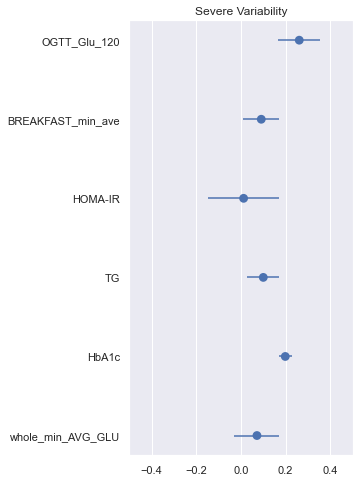

In [184]:
fig,ax = plt.subplots(figsize=(4,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_post.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_post['glucotype_sev'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_sev = []
lower_sev = []
upper_sev = []

for col in df_post.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_post[col],df_post['glucotype_sev'],alpha=0.05)
    lower_sev.append(lo)
    upper_sev.append(hi)
    pearson_sev.append(r)

ax.set_title("Severe Variability")
ax.errorbar(pearson_sev, y_coords, xerr=np.array([lower_sev,lower_sev]),fmt=' ')
ax.set_xlim([-.5,.5])
plt.show()

In [ ]:
glucotypes

In [176]:
glucotypes = ['glucotype_low','glucotype_mod','glucotype_sev']
times = ['Pre','Mid','Post']

dfout = pd.DataFrame(columns = ['ID','time', 'glucotype','glucovalue'])
i=0
for p in list(participants.values()):
    for t in times:
        for glu in glucotypes:
            if (t,glu) in p.features.keys():
                #print(glu,t,p.features[(t,glu)])
                dfout.loc[i] = [p.ID,t,glu,p.features[(t,glu)]]
                i+=1
dfout.to_excel("glucotypes.xlsx") 
dfout    

,ID,time,glucotype,glucovalue
0,102,Pre,glucotype_low,0.115385
1,102,Pre,glucotype_mod,0.288462
2,102,Pre,glucotype_sev,0.596154
3,102,Mid,glucotype_low,0.000000
4,102,Mid,glucotype_mod,0.134615
...,...,...,...,...
1027,174,Post,glucotype_mod,0.605263
1028,174,Post,glucotype_sev,0.394737
1029,309,Post,glucotype_low,0.052632
1030,309,Post,glucotype_mod,0.605263


In [ ]:
params = ['OGTT_Glu_120','BREAKFAST_min_ave','HOMA-IR','TG','HbA1c','whole_min_AVG_GLU','glucotype_low','glucotype_mod','glucotype_sev']


table_pre = [] #np.zeros(shape = (len(participants.values()),len(params)))
table_mid = []
table_post = []

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Pre', par) in p.features.keys():
            #print(p.ID,p.features[('Pre',par)],par)
            params_vals.append(p.features[('Pre',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_pre.append(params_vals)
table_pre = np.array(table_pre)
print(table_pre.shape)

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Mid', par) in p.features.keys():
            params_vals.append(p.features[('Mid',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_pre.append(params_vals)
table_mid = np.array(table_mid)
print(table_mid.shape)

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Post', par) in p.features.keys():
            params_vals.append(p.features[('Post',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_post.append(params_vals)
table_post = np.array(table_post)
print(table_post.shape)

df_pre = pd.DataFrame(table_pre, columns = params).replace('.',0).astype(float)
corr_pre = df_pre.corr(method='pearson')

fig,ax = plt.subplots(figsize=(15,15))
fig.suptitle('Pre',fontsize=16)
sns.heatmap(corr_pre, annot=True,cmap='seismic')
plt.show()

df_post = pd.DataFrame(table_post, columns = params).replace('.',0).astype(float)
corr_post = df_post.corr(method='pearson')

fig,ax = plt.subplots(figsize=(15,15))
fig.suptitle('Post',fontsize=16)
sns.heatmap(corr_post, annot=True,cmap='seismic')
plt.show()



(165, 8)
(0,)
(133, 8)


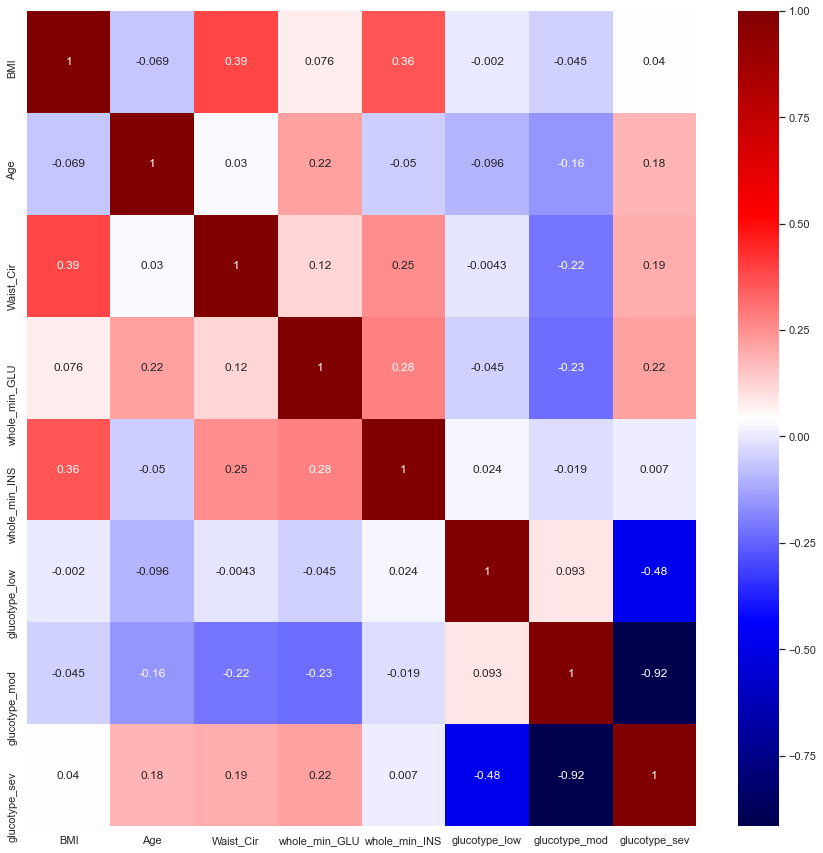

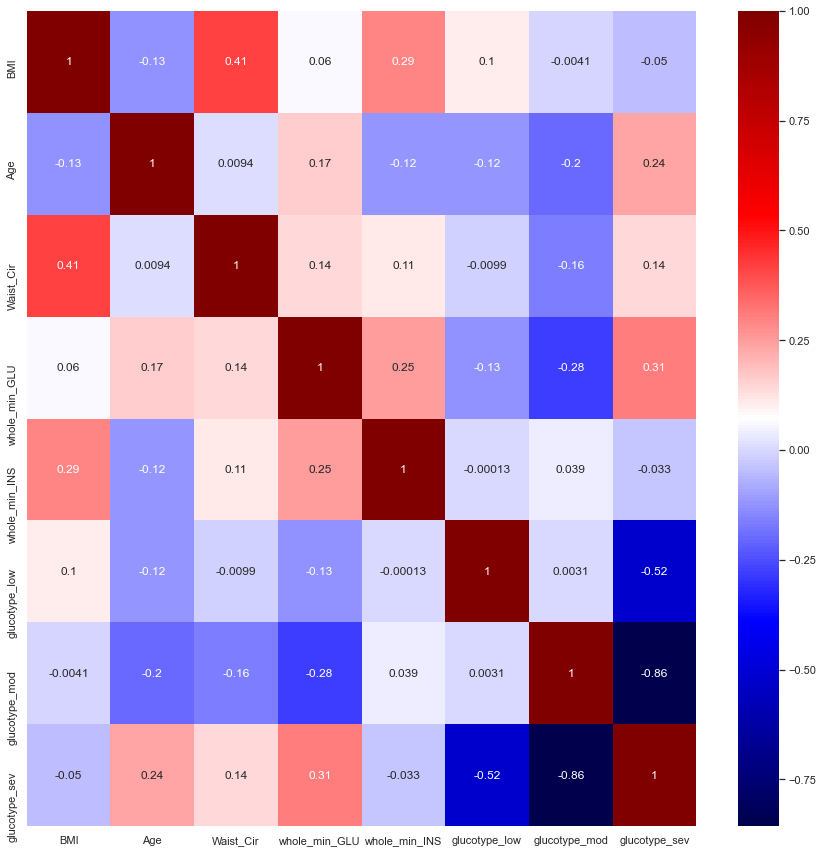

In [544]:
params = ['BMI','Age','Waist_Cir','whole_min_GLU','whole_min_INS','glucotype_low','glucotype_mod','glucotype_sev']


table_pre = [] #np.zeros(shape = (len(participants.values()),len(params)))
table_mid = []
table_post = []

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Pre', par) in p.features.keys():
            params_vals.append(p.features[('Pre',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_pre.append(params_vals)
table_pre = np.array(table_pre)
print(table_pre.shape)

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Mid', par) in p.features.keys():
            params_vals.append(p.features[('Mid',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_pre.append(params_vals)
table_mid = np.array(table_mid)
print(table_mid.shape)

for i,p in enumerate(list(participants.values())):
    params_vals = []
    for num,par in enumerate(params):
        if ('Post', par) in p.features.keys():
            params_vals.append(p.features[('Post',par)])
            #table_pre[i,num] = p.features[('Pre',par)]
    if len(params_vals) == len(params):
        table_post.append(params_vals)
table_post = np.array(table_post)
print(table_post.shape)

df_pre = pd.DataFrame(table_pre, columns = params)
corr_pre = df_pre.corr(method='pearson')

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_pre, annot=True,cmap='seismic')
plt.show()

df_post = pd.DataFrame(table_post, columns = params)
corr_post = df_post.corr(method='pearson')

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_post, annot=True,cmap='seismic')
plt.show()

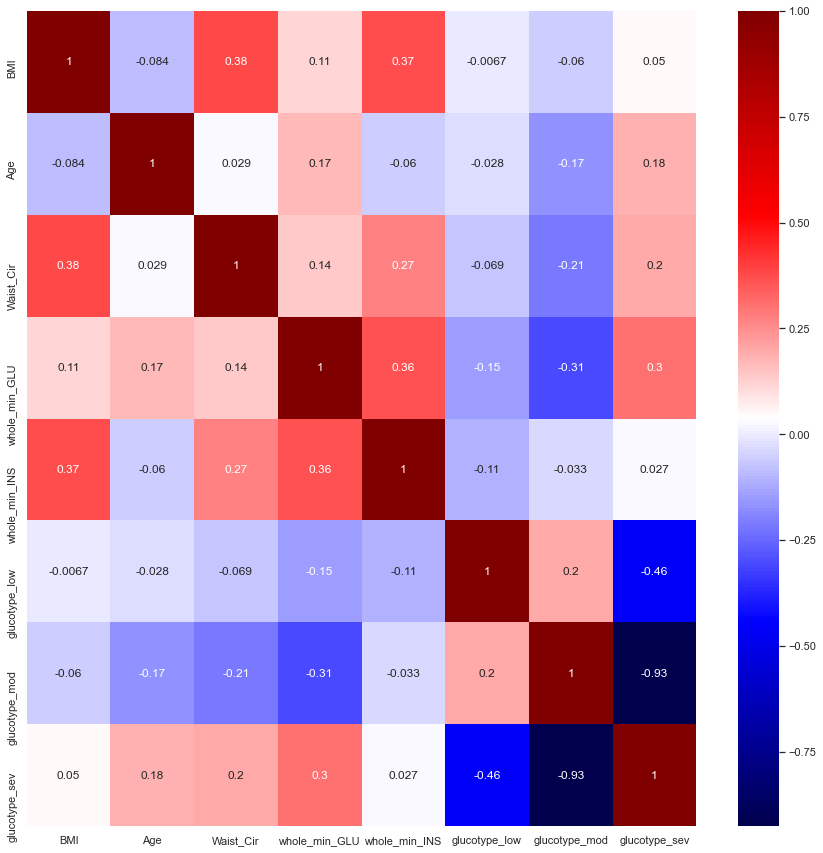

In [411]:
df_pre = pd.DataFrame(table_pre, columns = params)
corr = df_pre.corr(method='spearman')

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True,cmap='seismic')
plt.show()

In [135]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy

    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default

    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi




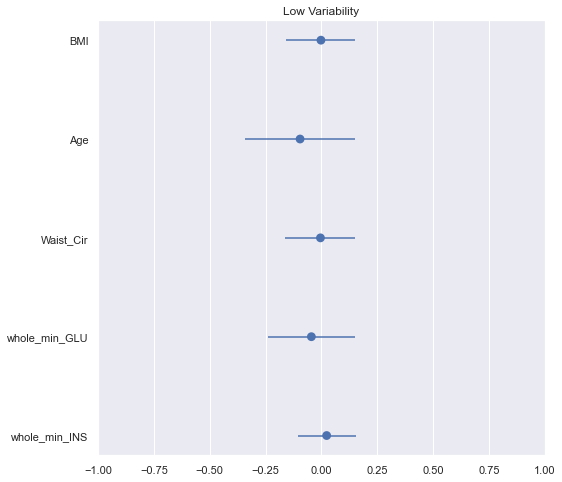

In [527]:
fig,ax = plt.subplots(figsize=(8,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_pre.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_pre['glucotype_low'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_low = []
lower_low = []
upper_low = []

for col in df_pre.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_pre[col],df_pre['glucotype_low'],alpha=0.05)
    lower_low.append(lo)
    upper_low.append(hi)
    pearson_low.append(r)

ax.set_title("Low Variability")
ax.errorbar(pearson_low, y_coords, xerr=np.array([lower_low,lower_low]),fmt=' ')
ax.set_xlim([-1,1])
plt.show()

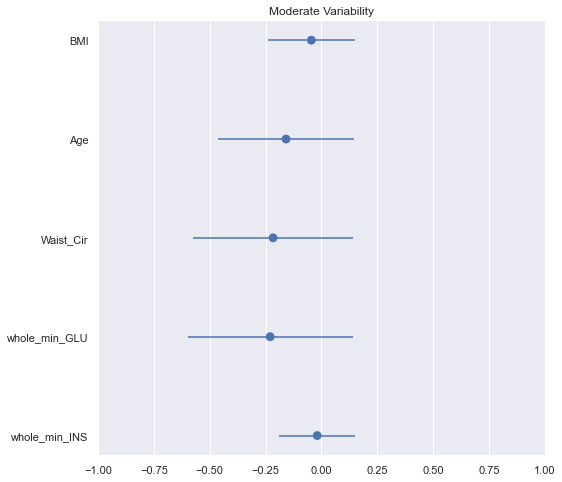

In [526]:
fig,ax = plt.subplots(figsize=(8,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_pre.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_pre['glucotype_mod'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_mod = []
lower_mod = []
upper_mod = []

for col in df_pre.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_pre[col],df_pre['glucotype_mod'],alpha=0.05)
    lower_mod.append(lo)
    upper_mod.append(hi)
    pearson_mod.append(r)

ax.set_title("Moderate Variability")
ax.errorbar(pearson_mod, y_coords, xerr=np.array([lower_mod,lower_mod]),fmt=' ')
ax.set_xlim([-1,1])
plt.show()

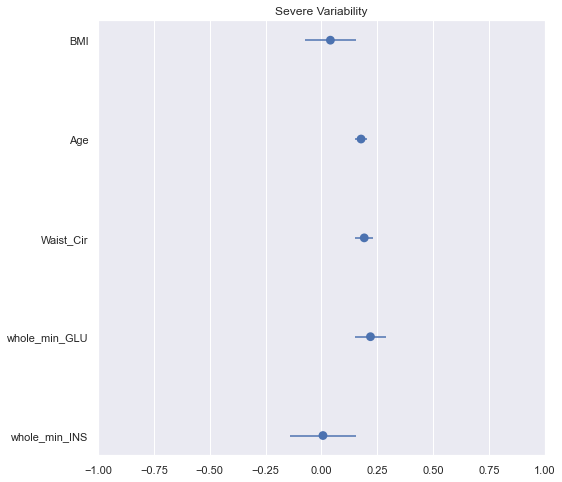

In [525]:
fig,ax = plt.subplots(figsize=(8,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_pre.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_pre['glucotype_sev'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_sev = []
lower_sev = []
upper_sev = []

for col in df_pre.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_pre[col],df_pre['glucotype_sev'],alpha=0.05)
    lower_sev.append(lo)
    upper_sev.append(hi)
    pearson_sev.append(r)

ax.set_title("Severe Variability")
ax.errorbar(pearson_sev, y_coords, xerr=np.array([lower_sev,lower_sev]),fmt=' ')
ax.set_xlim([-1,1])
plt.show()

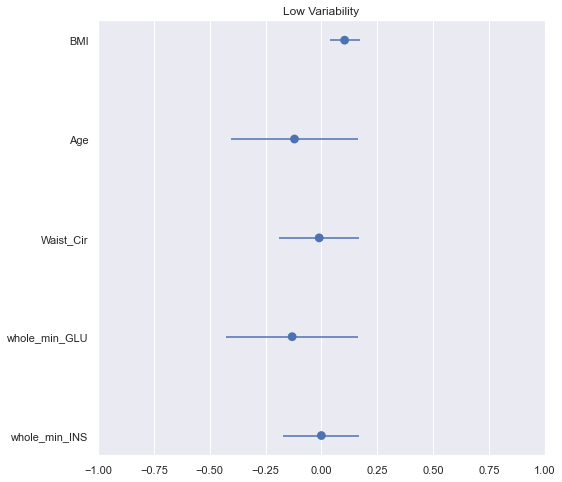

In [545]:
fig,ax = plt.subplots(figsize=(8,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_post.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_post['glucotype_low'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_low = []
lower_low = []
upper_low = []

for col in df_post.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_post[col],df_post['glucotype_low'],alpha=0.05)
    lower_low.append(lo)
    upper_low.append(hi)
    pearson_low.append(r)

ax.set_title("Low Variability")
ax.errorbar(pearson_low, y_coords, xerr=np.array([lower_low,lower_low]),fmt=' ')
ax.set_xlim([-1,1])
plt.show()

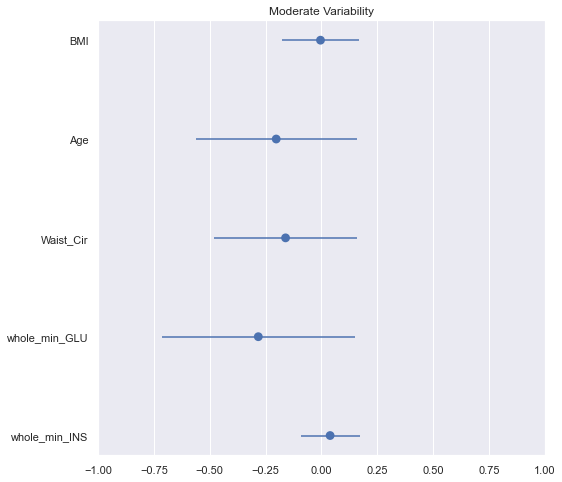

In [546]:
fig,ax = plt.subplots(figsize=(8,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_post.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_post['glucotype_mod'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_mod = []
lower_mod = []
upper_mod = []

for col in df_post.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_post[col],df_post['glucotype_mod'],alpha=0.05)
    lower_mod.append(lo)
    upper_mod.append(hi)
    pearson_mod.append(r)

ax.set_title("Moderate Variability")
ax.errorbar(pearson_mod, y_coords, xerr=np.array([lower_mod,lower_mod]),fmt=' ')
ax.set_xlim([-1,1])
plt.show()

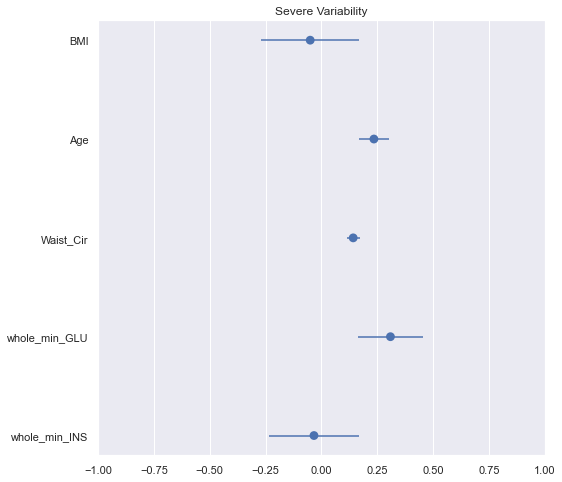

In [547]:
fig,ax = plt.subplots(figsize=(8,8))
sns.set_theme(style="darkgrid")
ax = sns.pointplot(data=df_post.iloc[:,:-3],estimator = lambda x: pearsonr(x,df_post['glucotype_sev'])[0],orient='h',markers="o",linestyles=" ", join=False,capsize=.1,ci=None)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
#print(x_coords,y_coords,upper)
# Calculate the type of error to plot as the error bars
# Make sure the order is the same as the points were looped over

pearson_sev = []
lower_sev = []
upper_sev = []

for col in df_post.iloc[:,:-3]:

    r, p, lo, hi = pearsonr_ci(df_post[col],df_post['glucotype_sev'],alpha=0.05)
    lower_sev.append(lo)
    upper_sev.append(hi)
    pearson_sev.append(r)

ax.set_title("Severe Variability")
ax.errorbar(pearson_sev, y_coords, xerr=np.array([lower_sev,lower_sev]),fmt=' ')
ax.set_xlim([-1,1])
plt.show()

(26, 9)


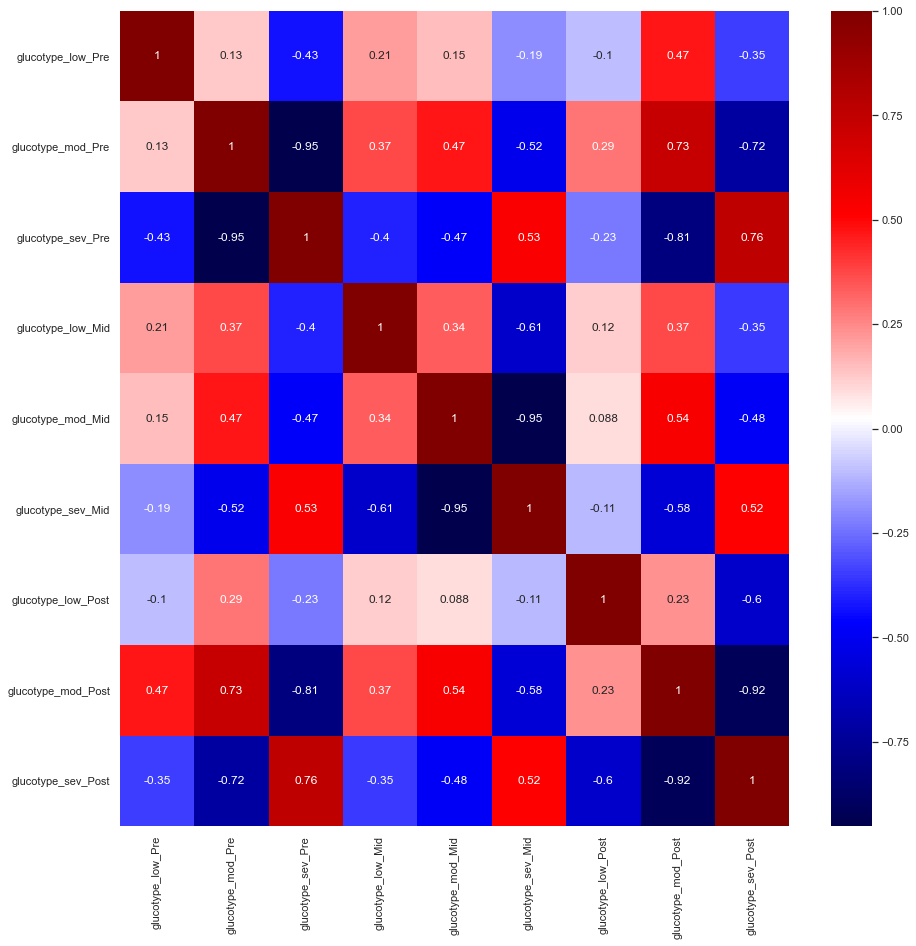

In [140]:
params = ['glucotype_low','glucotype_mod','glucotype_sev']

table= [] #np.zeros(shape = (len(participants.values()),len(params)))

for i,p in enumerate(list(participants.values())):
    table_in = []
    for num,par in enumerate(params):
        params_vals = []
        for j,s in enumerate(study_types):
            if (s, par) in p.features.keys():
                params_vals.append(p.features[(s,par)])
                #table_pre[i,num] = p.features[('Pre',par)]
        if len(params_vals) == len(params):
            table_in.append(params_vals)
    if len(table_in) == 3:
        #table.append(np.array(table_in).flatten())
        table.append([p.features[(sj,pari)] for sj in study_types for pari in params ])
table = np.array(table)
print(table.shape)

df3 = pd.DataFrame(table, columns = ["{0}_{1}".format(pari,sj) for sj in study_types for pari in params ])
corr3 = df3.corr(method='pearson')

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr3, annot=True,cmap='seismic')
plt.show()

In [255]:
# import R's utility package
utils = rpackages.importr('utils')

shiny_r = rpackages.importr('shiny')
DT_r = rpackages.importr('DT')
dygraphs_r = rpackages.importr('dygraphs')
ggplot2_r = rpackages.importr('ggplot2')
lubridate_r = rpackages.importr('lubridate')
xts_r = rpackages.importr('xts',on_conflict="warn")
scales_r = rpackages.importr('scales')

r = robjects.r
r['source']('shinySpecClust/classify_mod.R')

#paramF = "shinySpecClust/train.overlap_37+window_2.5.params.Rdata"
#r['load'](paramF)

#windowsF= "shinySpecClust/rawDexcomSeries+overlap_37+window_2.5+user_all"
#train_windows_r = r['fread'](windowsF)

r('''
    df_to_xts = function(df) {
    ts = xts(df[,-1], order.by=ymd_hms(df[,1]))
        return(ts)
    }
    ''')
df_to_xts_r = robjects.globalenv["df_to_xts"]

r('''
    read_cgmF = function(f) {
        df = tryCatch( {
                read.table(f, sep='\t', h=T, quote="")},
                error=function(e)
                read.table(f, sep='\t',
                        fileEncoding="UTF-16LE", h=T, quote="")
        )
        df[[1]] = ymd_hms(df[[1]])
        return (df)
}
''')

read_cgmF_r = robjects.globalenv["read_cgmF"]

In [282]:
for p in list(participants.values())[:1]:
    studies = []
    if any(p.studies):
        studies = list(set(np.array(list(p.studies.keys()))[:,0]))
    for s in studies:
        p.export_file(s)
        cgm_r = r['read_cgmF']("cgm.tsv")

        res_r = r['classify_glucotype'](cgm_r)
        p.add_feature((s,'res'),res_r)
        #low,mod,sev = list(freq_r[0])
        print(p.ID,s,res_r)
        
        #p.add_feature((s,'glucotype_low'),low)
        #p.add_feature((s,'glucotype_mod'),mod)
        #p.add_feature((s,'glucotype_sev'),sev)

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
102 Post $test
$test$test
            x.1          x.2          x.3          x.4          x.5
 1: -0.64322306 -1.017017812 -1.235279577 -1.355581337 -1.487483624
 2: -2.39748051 -2.412088580 -2.463216828 -2.523367708 -2.575355254
 3: -2.59683771 -2.548717008 -2.544850165 -2.580511044 -2.620468415
 4: -1.68340363 -1.585013979 -1.352573793 -1.105955185 -0.921206053
 5:  0.56537998  0.689118935  0.721342621  0.741536131  0.772900518
 6: -0.48081568 -0.511320771 -0.484682524 -0.422383398 -0.364810413
 7:  1.56689213  1.594819329  1.593530382  1.544120730  1.395462127
 8:  0.85582280  1.062913690  1.229617558  1.286331244  1.172474221
 9:  0.30114576  0.231112949  0.203615404  0.207052597  0.200607860
10: -0.26470216 -0.210136721 -0.106161629 -0.021950397  0.011132587
11:  1.91275970  1.996111629  2.051536368  2.076456019  2.066144439
12: -0.83699482 -0.416368310  0.060542239  0.401254009  0.597603668
13:  0.43347770  0.456678749  0.455819451  0.42832

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
102 Mid $test
$test$test
            x.1         x.2         x.3         x.4         x.5         x.6
 1:  0.27235927  0.29083418  0.25517330  0.20920084  0.15893189  0.10608505
 2: -0.38844112 -0.39789340 -0.40691603 -0.40992357 -0.41851656 -0.43656182
 3: -0.50186849 -0.51132077 -0.51647656 -0.51819516 -0.51819516 -0.51647656
 4: -0.34590585 -0.32098620 -0.28360672 -0.23118953 -0.16416426 -0.08854601
 5:  0.64572437  0.63412385  0.61736753  0.59158858  0.56280209  0.53358595
 6:  0.43347770  0.58256595  0.82273982  1.12220527  1.45561301  1.80534741
 7:  1.61243494  1.41436669  1.21930598  1.03885334  0.88804649  0.77375982
 8:  0.18943698  0.34282173  0.49921401  0.64486507  0.75270701  0.81113929
 9:  0.32391716  0.30630155  0.29212313  0.28052260  0.28009295  0.29341207
10:  0.23755769  0.22552751  0.21693453  0.21134909  0.20662295  0.19888926
11:  1.01737088  1.08568509  1.14712492  1.20512756  1.26313019  1.32371072
12:  1.16345159  1.1866

[1] "Prepare test"


R[write to console]: pad applied on the interval: 5 min



[1] "Prepare training"
[1] "Predicting"
102 Pre $test
$test$test
            x.1          x.2           x.3          x.4         x.5         x.6
 1:  0.01886627 -0.256109180 -0.4803860323 -0.687906569 -0.87007781 -1.01057308
 2: -0.86406272 -0.926361843 -0.9774900910 -1.017017812 -1.04408571 -1.05439729
 3: -0.74934640 -0.753642887 -0.7471981503 -0.717982009 -0.65224569 -0.56975305
 4: -0.85890693 -0.853751138 -0.8417209618 -0.821527452 -0.79703745 -0.76782131
 5:  0.48331700  0.562802087  0.6302570028  0.664628934  0.68525209  0.70501595
 6:  0.72220192  0.554638754  0.3754750609  0.238846633  0.17139172  0.18213295
 7: -0.31797866 -0.324423393 -0.3291495339 -0.311104270 -0.27200620 -0.20541058
 8:  0.99631807  0.879023857  0.7243501651  0.552920157  0.37504541  0.19072593
 9: -1.24129466 -1.254613788 -1.2700811575 -1.294571159 -1.33152098 -1.36761151
10: -0.60068779 -0.588657616 -0.5856500724 -0.608851126 -0.64708990 -0.67372815
11: -0.47480059 -0.424101995 -0.3463354997 -0.208418125

In [330]:
participants[102].features[('Pre','res')]

train_Y,[RTYPES.REALSXP]
train,[RTYPES.VECSXP]
train_means,[RTYPES.REALSXP]
train_CE,[RTYPES.REALSXP]
train_labels,[RTYPES.INTSXP]
centers,[RTYPES.REALSXP]


In [285]:
participants[102].studies

{('Pre', '1'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Pre', '2'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Pre', '3'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Pre', '4'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Mid', '1'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Mid', '2'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Mid', '3'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Mid', '4'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Post', '1'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Post', '2'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Post', '3'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Post', '4'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>,
 ('Post', '5'): CGM_x <class 'numpy.ndarray'> CGM_y <class 'numpy.ndarray'>}

In [287]:
len(participants[102].studies[('Pre','1')].CGM_y),len( participants[102].studies[('Pre','2')].CGM_y),len(participants[102].studies[('Pre','3')].CGM_y),len( participants[102].studies[('Pre','4')].CGM_y)

(288, 288, 288, 288)

In [290]:
len(participants[102].studies[('Pre','1')].CGM_y)*4

1152

In [306]:
24*60*4/5

1152.0

In [291]:
2.5*60

150.0

In [313]:
202+52

254